# Loading packages

In [1]:
!pip install medmnist
!pip install evaluate
!pip install wandb
!pip install fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.9 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha25

In [ ]:
from transformers import ViTImageProcessor, ViTForImageClassification, ViTConfig, ViTModel
from PIL import Image
import requests
from medmnist import OCTMNIST, PathMNIST, DermaMNIST, RetinaMNIST, BloodMNIST
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from medmnist import INFO, Evaluator
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
from evaluate import load
from transformers import TrainingArguments, Trainer
import os
from fastai.vision.augment import Resize, ResizeMethod
from data_augmentation import ConcatDataset, UpdateLabelsMNSIT, DatasetAugmentation
from collections import defaultdict
import json
from google.colab import files

# Loading Train Data

In [3]:
path_dataset = PathMNIST(split="train", download=True)
derma_dataset = DermaMNIST(split="train", download=True)
blood_dataset = BloodMNIST(split="train", download=True)
retina_dataset = RetinaMNIST(split="train", download=True)

100%|██████████| 206M/206M [00:12<00:00, 16.5MB/s]
100%|██████████| 19.7M/19.7M [00:01<00:00, 10.6MB/s]
100%|██████████| 35.5M/35.5M [00:02<00:00, 13.1MB/s]
100%|██████████| 3.29M/3.29M [00:01<00:00, 2.84MB/s]


# Loading Validation Data

In [4]:
val_path_dataset = PathMNIST(split="val", download=True)
val_derma_dataset = DermaMNIST(split="val", download=True)
val_blood_dataset = BloodMNIST(split="val", download=True)
val_retina_dataset = RetinaMNIST(split="val", download=True)

# Loading Test Data

In [5]:
test_path_dataset = PathMNIST(split="test", download=True)
test_derma_dataset = DermaMNIST(split="test", download=True)
test_blood_dataset = BloodMNIST(split="test", download=True)
test_retina_dataset = RetinaMNIST(split="test", download=True)

# Extracting Labels

In [6]:
pathmnist_info = INFO["pathmnist"]
dermamnist_info = INFO["dermamnist"]
bloodmnist_info = INFO["bloodmnist"]
retinamnist_info = INFO["retinamnist"]

path_labels = pathmnist_info["label"].values()
derma_labels = dermamnist_info["label"].values()
blood_labels = bloodmnist_info["label"].values()
retina_labels = retinamnist_info["label"].values()

In [7]:
labels = list(path_labels) + list(derma_labels) + list(blood_labels) + list(retina_labels)
labels

['adipose',
 'background',
 'debris',
 'lymphocytes',
 'mucus',
 'smooth muscle',
 'normal colon mucosa',
 'cancer-associated stroma',
 'colorectal adenocarcinoma epithelium',
 'actinic keratoses and intraepithelial carcinoma',
 'basal cell carcinoma',
 'benign keratosis-like lesions',
 'dermatofibroma',
 'melanoma',
 'melanocytic nevi',
 'vascular lesions',
 'basophil',
 'eosinophil',
 'erythroblast',
 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)',
 'lymphocyte',
 'monocyte',
 'neutrophil',
 'platelet',
 '0',
 '1',
 '2',
 '3',
 '4']

# Data Augmentation and Concatenation

In [8]:
import torchvision.transforms as T

class CustomMNIST(Dataset):
  def __init__(self, dataset, *args, **kwargs):

    super(CustomMNIST, self).__init__()

    self.data_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[.5], std=[.5])
      ])

    self.dataset = dataset
    self.transform = T.ToPILImage()

  def __len__(self):
    return len(self.dataset)


  def __getitem__(self, idx):
    image, label = self.dataset[idx]

    if isinstance(image, torch.Tensor):
          image = self.transform(image)

    image = self.data_transform(image)

    item = {'pixel_values' : image, 'labels' : label}
    return item


In [9]:
train_subset = 1080
concat_dataset = ConcatDataset(path_dataset, derma_dataset, blood_dataset, retina_dataset, train_subset)
augmented_dataset = DatasetAugmentation(concat_dataset)
train_dataset = CustomMNIST(augmented_dataset)

Concatenating datasets


In [10]:
validation_subset = 120
concat_val_dataset = ConcatDataset(val_path_dataset, val_derma_dataset, val_blood_dataset, val_retina_dataset, validation_subset)
val_dataset = CustomMNIST(concat_val_dataset)

Concatenating datasets


In [11]:
test_subset = 400
concat_test_dataset = ConcatDataset(test_path_dataset, test_derma_dataset, test_blood_dataset, test_retina_dataset, test_subset)
test_dataset = CustomMNIST(concat_test_dataset)

Concatenating datasets


# Evaluation Metrics

In [12]:
metric = load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [13]:
def metrics_evaluation(test_dataset, k):

  correct_predictions = 0
  recall = 0
  precision = 0

  labels_dict = defaultdict(lambda: {'true_positives': 0, 'false_negatives': 0, 'false_positives': 0})
  metrics = {}

  for idx in range(len(test_dataset)):
    image = test_dataset[idx]['pixel_values'].to(model.device)
    outputs = model(image.unsqueeze(0))
    logits = outputs.logits

    values, indices = torch.topk(logits, k)

    pred_labels = indices.squeeze().tolist()
    real_label =  test_dataset[idx]['labels'].item()

    if isinstance(pred_labels, int):
      pred_labels = [pred_labels]

    if real_label in pred_labels:
      correct_predictions += 1
      for label in pred_labels:
        labels_dict[label]['true_positives']+=1

    else:
      for label in pred_labels:
        labels_dict[label]['false_positives']+=1
        labels_dict[real_label]['false_negatives']+=1

  metrics['accuracy'] = (correct_predictions / len(test_dataset))
  print('------------------------------------------------------------------')
  print(f"Fine-tuning Top-{k} Accuracy on test dataset: {metrics['accuracy']*100}%")

  for label, value in labels_dict.items():
    if value['true_positives'] == 0:
      continue
    precision = precision + value['true_positives'] / (value['true_positives'] + value['false_positives'])
    recall = recall + value['true_positives'] / (value['true_positives'] + value['false_negatives'])

  metrics['recall'] = (recall / len(labels_dict))
  metrics['precision'] = (precision / len(labels_dict))
  metrics['f1-score'] = (2*(metrics['recall']*metrics['precision'])/(metrics['recall']+metrics['precision']))

  print(f"Fine-tuning Top-{k} Recall on test dataset: {metrics['recall']*100}%")
  print(f"Fine-tuning Top-{k} Precision on test dataset: {metrics['precision']*100}%")
  print(f"Fine-tuning Top-{k} F1-Score on test dataset: {metrics['f1-score']*100}%")


  return metrics

In [14]:
os.environ["WANDB_DISABLED"] = "true"

# Selecting optimal hyperparameters

In [ ]:
lr = [1e-3, 1e-4, 1e-5, 5e-5]
warm_ratio = [0, 0.1, 0.2]
weight_decay = [0, 0.01, 0.1]

for lr_value in lr:
  for warm_ratio_value in warm_ratio:
    for weight_decay_value in weight_decay:
        print('-------------------------------')
        print(f'Learning Rate: {lr_value}')
        print(f'Warmup Ratio: {warm_ratio_value}')
        print(f'Weight Decay: {weight_decay_value}')
        device="cuda" if torch.cuda.is_available() else "cpu"

        processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
        model = ViTForImageClassification.from_pretrained(
          'google/vit-base-patch16-224',
          num_labels=len(labels),
          id2label={str(i): c for i, c in enumerate(labels)},
          label2id={c: str(i) for i, c in enumerate(labels)},
          ignore_mismatched_sizes = True
          ).to(device)


        training_arguments = TrainingArguments(
          learning_rate = lr_value,
          lr_scheduler_type="cosine",
          num_train_epochs=2,
          per_device_train_batch_size=16,
          per_device_eval_batch_size=16,
          warmup_ratio = warm_ratio_value,
          weight_decay = weight_decay_value,
          report_to="none"
          )

        trainer = Trainer(
            model=model,
            args=training_arguments,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            )

        train_results = trainer.train()


        metrics = trainer.evaluate(val_dataset)
        trainer.log_metrics("eval", metrics)
        trainer.save_metrics("eval", metrics)


        with open("Vit_hyperparameters_choice.txt", "a") as f:
          f.write("---------------------------------\n")
          f.write(f"Learning Rate: {lr_value}\n")
          f.write(f"Warmup Ratio: {warm_ratio_value}\n")
          f.write(f"Weight Decay: {weight_decay_value}\n")
          f.write("Metrics:\n")
          for metric_name, metric_value in metrics.items():
              f.write(f"  {metric_name}: {metric_value}\n")
          f.write("\n")


-------------------------------
Learning Rate: 0.001
Warmup Ratio: 0
Weight Decay: 0


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.344600
1000,1.726200
1500,1.531000
2000,1.356100
2500,1.200400
3000,1.067700
3500,0.991400
4000,0.907200


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7188
  eval_loss               =     0.7278
  eval_runtime            = 0:00:02.91
  eval_samples_per_second =    164.835
  eval_steps_per_second   =     10.302
-------------------------------
Learning Rate: 0.001
Warmup Ratio: 0
Weight Decay: 0.01


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.301900
1000,1.743100
1500,1.531700
2000,1.341100
2500,1.182900
3000,1.030900
3500,0.955600
4000,0.862100


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7229
  eval_loss               =     0.7458
  eval_runtime            = 0:00:02.89
  eval_samples_per_second =    165.652
  eval_steps_per_second   =     10.353
-------------------------------
Learning Rate: 0.001
Warmup Ratio: 0
Weight Decay: 0.1


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.227600
1000,1.611600
1500,1.413200
2000,1.241900
2500,1.105500
3000,0.981200
3500,0.902200
4000,0.810500


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7083
  eval_loss               =     0.7156
  eval_runtime            = 0:00:02.89
  eval_samples_per_second =    165.848
  eval_steps_per_second   =     10.365
-------------------------------
Learning Rate: 0.001
Warmup Ratio: 0.1
Weight Decay: 0


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.728500
1000,1.551500
1500,1.321700
2000,1.172900
2500,1.001500
3000,0.884100
3500,0.774000
4000,0.693300


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7417
  eval_loss               =     0.6408
  eval_runtime            = 0:00:02.90
  eval_samples_per_second =    165.209
  eval_steps_per_second   =     10.326
-------------------------------
Learning Rate: 0.001
Warmup Ratio: 0.1
Weight Decay: 0.01


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.706600
1000,1.533600
1500,1.319500
2000,1.158000
2500,0.997400
3000,0.874400
3500,0.775100
4000,0.680900


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7542
  eval_loss               =     0.6514
  eval_runtime            = 0:00:02.87
  eval_samples_per_second =    166.749
  eval_steps_per_second   =     10.422
-------------------------------
Learning Rate: 0.001
Warmup Ratio: 0.1
Weight Decay: 0.1


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.700900
1000,1.555800
1500,1.333200
2000,1.195000
2500,1.027300
3000,0.904100
3500,0.791200
4000,0.694300


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7542
  eval_loss               =     0.6417
  eval_runtime            = 0:00:02.90
  eval_samples_per_second =    165.245
  eval_steps_per_second   =     10.328
-------------------------------
Learning Rate: 0.001
Warmup Ratio: 0.2
Weight Decay: 0


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.532500
1000,1.532800
1500,1.383000
2000,1.217900
2500,1.041500
3000,0.905700
3500,0.799200
4000,0.688600


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7396
  eval_loss               =     0.6621
  eval_runtime            = 0:00:02.96
  eval_samples_per_second =    161.704
  eval_steps_per_second   =     10.107
-------------------------------
Learning Rate: 0.001
Warmup Ratio: 0.2
Weight Decay: 0.01


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.531700
1000,1.530200
1500,1.435300
2000,1.225200
2500,1.050600
3000,0.930100
3500,0.813900
4000,0.700100


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7438
  eval_loss               =      0.656
  eval_runtime            = 0:00:02.89
  eval_samples_per_second =    165.709
  eval_steps_per_second   =     10.357
-------------------------------
Learning Rate: 0.001
Warmup Ratio: 0.2
Weight Decay: 0.1


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.514900
1000,1.512700
1500,1.409700
2000,1.247800
2500,1.079300
3000,0.938300
3500,0.823300
4000,0.703200


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7521
  eval_loss               =     0.6416
  eval_runtime            = 0:00:02.93
  eval_samples_per_second =    163.357
  eval_steps_per_second   =      10.21
-------------------------------
Learning Rate: 0.0001
Warmup Ratio: 0
Weight Decay: 0


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.139100
1000,0.791500
1500,0.663200
2000,0.540800
2500,0.371200
3000,0.256300
3500,0.201100
4000,0.141900


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7792
  eval_loss               =     0.6627
  eval_runtime            = 0:00:02.98
  eval_samples_per_second =    160.936
  eval_steps_per_second   =     10.059
-------------------------------
Learning Rate: 0.0001
Warmup Ratio: 0
Weight Decay: 0.01


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.139500
1000,0.781800
1500,0.670200
2000,0.540300
2500,0.367800
3000,0.250300
3500,0.206400
4000,0.148000


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =        0.8
  eval_loss               =     0.6628
  eval_runtime            = 0:00:02.90
  eval_samples_per_second =    165.412
  eval_steps_per_second   =     10.338
-------------------------------
Learning Rate: 0.0001
Warmup Ratio: 0
Weight Decay: 0.1


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.127200
1000,0.803600
1500,0.680300
2000,0.555100
2500,0.376300
3000,0.274000
3500,0.215300
4000,0.154400


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =      0.775
  eval_loss               =     0.6631
  eval_runtime            = 0:00:02.93
  eval_samples_per_second =    163.553
  eval_steps_per_second   =     10.222
-------------------------------
Learning Rate: 0.0001
Warmup Ratio: 0.1
Weight Decay: 0


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.556300
1000,0.842600
1500,0.716700
2000,0.575100
2500,0.389300
3000,0.276200
3500,0.214000
4000,0.146600


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7979
  eval_loss               =     0.6796
  eval_runtime            = 0:00:02.87
  eval_samples_per_second =    166.944
  eval_steps_per_second   =     10.434
-------------------------------
Learning Rate: 0.0001
Warmup Ratio: 0.1
Weight Decay: 0.01


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.546200
1000,0.849800
1500,0.718800
2000,0.581400
2500,0.394400
3000,0.286300
3500,0.215700
4000,0.151400


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7896
  eval_loss               =     0.6589
  eval_runtime            = 0:00:02.92
  eval_samples_per_second =    163.864
  eval_steps_per_second   =     10.242
-------------------------------
Learning Rate: 0.0001
Warmup Ratio: 0.1
Weight Decay: 0.1


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.547500
1000,0.841200
1500,0.721700
2000,0.582100
2500,0.410000
3000,0.285800
3500,0.223800
4000,0.158400


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.8021
  eval_loss               =     0.6489
  eval_runtime            = 0:00:02.85
  eval_samples_per_second =    168.191
  eval_steps_per_second   =     10.512
-------------------------------
Learning Rate: 0.0001
Warmup Ratio: 0.2
Weight Decay: 0


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.734900
1000,0.887600
1500,0.786100
2000,0.629800
2500,0.457300
3000,0.336200
3500,0.257100
4000,0.181500


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7896
  eval_loss               =      0.646
  eval_runtime            = 0:00:02.94
  eval_samples_per_second =    162.744
  eval_steps_per_second   =     10.172
-------------------------------
Learning Rate: 0.0001
Warmup Ratio: 0.2
Weight Decay: 0.01


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.739700
1000,0.878200
1500,0.787200
2000,0.636300
2500,0.458500
3000,0.333700
3500,0.251400
4000,0.178500


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7937
  eval_loss               =     0.6368
  eval_runtime            = 0:00:02.91
  eval_samples_per_second =    164.489
  eval_steps_per_second   =     10.281
-------------------------------
Learning Rate: 0.0001
Warmup Ratio: 0.2
Weight Decay: 0.1


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.736200
1000,0.876500
1500,0.785100
2000,0.635900
2500,0.458700
3000,0.334800
3500,0.262000
4000,0.177500


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7958
  eval_loss               =     0.6179
  eval_runtime            = 0:00:02.89
  eval_samples_per_second =    165.674
  eval_steps_per_second   =     10.355
-------------------------------
Learning Rate: 1e-05
Warmup Ratio: 0
Weight Decay: 0


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.772200
1000,0.949100
1500,0.805400
2000,0.711100
2500,0.600200
3000,0.552500
3500,0.542100
4000,0.523900


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7833
  eval_loss               =      0.568
  eval_runtime            = 0:00:02.88
  eval_samples_per_second =     166.54
  eval_steps_per_second   =     10.409
-------------------------------
Learning Rate: 1e-05
Warmup Ratio: 0
Weight Decay: 0.01


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.779700
1000,0.950100
1500,0.804300
2000,0.711100
2500,0.600600
3000,0.549800
3500,0.542300
4000,0.524900


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7833
  eval_loss               =     0.5631
  eval_runtime            = 0:00:02.90
  eval_samples_per_second =    165.317
  eval_steps_per_second   =     10.332
-------------------------------
Learning Rate: 1e-05
Warmup Ratio: 0
Weight Decay: 0.1


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.775500
1000,0.947600
1500,0.803600
2000,0.707500
2500,0.597900
3000,0.547000
3500,0.541500
4000,0.522100


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7937
  eval_loss               =     0.5596
  eval_runtime            = 0:00:02.92
  eval_samples_per_second =    163.924
  eval_steps_per_second   =     10.245
-------------------------------
Learning Rate: 1e-05
Warmup Ratio: 0.1
Weight Decay: 0


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.469300
1000,1.091400
1500,0.844900
2000,0.732200
2500,0.615200
3000,0.562700
3500,0.550500
4000,0.531300


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7875
  eval_loss               =     0.5535
  eval_runtime            = 0:00:02.89
  eval_samples_per_second =    165.747
  eval_steps_per_second   =     10.359
-------------------------------
Learning Rate: 1e-05
Warmup Ratio: 0.1
Weight Decay: 0.01


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.467600
1000,1.090000
1500,0.845200
2000,0.734900
2500,0.616200
3000,0.563500
3500,0.550000
4000,0.530500


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7958
  eval_loss               =     0.5522
  eval_runtime            = 0:00:02.91
  eval_samples_per_second =    164.789
  eval_steps_per_second   =     10.299
-------------------------------
Learning Rate: 1e-05
Warmup Ratio: 0.1
Weight Decay: 0.1


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.471700
1000,1.092300
1500,0.847300
2000,0.733700
2500,0.614400
3000,0.564800
3500,0.551000
4000,0.530900


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7917
  eval_loss               =     0.5449
  eval_runtime            = 0:00:02.89
  eval_samples_per_second =     166.09
  eval_steps_per_second   =     10.381
-------------------------------
Learning Rate: 1e-05
Warmup Ratio: 0.2
Weight Decay: 0


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.784100
1000,1.384900
1500,0.919200
2000,0.769900
2500,0.640000
3000,0.582400
3500,0.564400
4000,0.538000


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7833
  eval_loss               =     0.5529
  eval_runtime            = 0:00:02.90
  eval_samples_per_second =    165.412
  eval_steps_per_second   =     10.338
-------------------------------
Learning Rate: 1e-05
Warmup Ratio: 0.2
Weight Decay: 0.01


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.787000
1000,1.382600
1500,0.915200
2000,0.767200
2500,0.636600
3000,0.579300
3500,0.561800
4000,0.536900


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7854
  eval_loss               =     0.5526
  eval_runtime            = 0:00:02.94
  eval_samples_per_second =    162.776
  eval_steps_per_second   =     10.174
-------------------------------
Learning Rate: 1e-05
Warmup Ratio: 0.2
Weight Decay: 0.1


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.783900
1000,1.383900
1500,0.917500
2000,0.768400
2500,0.637500
3000,0.580300
3500,0.563800
4000,0.536400


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7812
  eval_loss               =     0.5497
  eval_runtime            = 0:00:02.87
  eval_samples_per_second =    167.117
  eval_steps_per_second   =     10.445
-------------------------------
Learning Rate: 5e-05
Warmup Ratio: 0
Weight Decay: 0


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.156500
1000,0.733900
1500,0.633400
2000,0.515200
2500,0.349300
3000,0.255400
3500,0.216300
4000,0.175600


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =        0.8
  eval_loss               =     0.6064
  eval_runtime            = 0:00:02.90
  eval_samples_per_second =    165.298
  eval_steps_per_second   =     10.331
-------------------------------
Learning Rate: 5e-05
Warmup Ratio: 0
Weight Decay: 0.01


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.154600
1000,0.728700
1500,0.638400
2000,0.518000
2500,0.352200
3000,0.255600
3500,0.223200
4000,0.182400


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.8083
  eval_loss               =     0.5835
  eval_runtime            = 0:00:02.89
  eval_samples_per_second =    165.889
  eval_steps_per_second   =     10.368
-------------------------------
Learning Rate: 5e-05
Warmup Ratio: 0
Weight Decay: 0.1


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.165200
1000,0.733500
1500,0.638600
2000,0.521100
2500,0.353000
3000,0.256900
3500,0.216300
4000,0.175300


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.8063
  eval_loss               =     0.5946
  eval_runtime            = 0:00:02.86
  eval_samples_per_second =    167.342
  eval_steps_per_second   =     10.459
-------------------------------
Learning Rate: 5e-05
Warmup Ratio: 0.1
Weight Decay: 0


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.736600
1000,0.816700
1500,0.690700
2000,0.564800
2500,0.397300
3000,0.295000
3500,0.251100
4000,0.197400


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.8083
  eval_loss               =     0.5801
  eval_runtime            = 0:00:02.90
  eval_samples_per_second =    165.429
  eval_steps_per_second   =     10.339
-------------------------------
Learning Rate: 5e-05
Warmup Ratio: 0.1
Weight Decay: 0.01


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.737700
1000,0.816100
1500,0.687900
2000,0.561000
2500,0.394300
3000,0.292200
3500,0.240400
4000,0.191200


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7958
  eval_loss               =     0.5909
  eval_runtime            = 0:00:02.89
  eval_samples_per_second =    165.542
  eval_steps_per_second   =     10.346
-------------------------------
Learning Rate: 5e-05
Warmup Ratio: 0.1
Weight Decay: 0.1


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.736900
1000,0.818000
1500,0.690900
2000,0.566600
2500,0.396800
3000,0.297200
3500,0.247100
4000,0.198800


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.8083
  eval_loss               =     0.5701
  eval_runtime            = 0:00:02.90
  eval_samples_per_second =    165.088
  eval_steps_per_second   =     10.318
-------------------------------
Learning Rate: 5e-05
Warmup Ratio: 0.2
Weight Decay: 0


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.013800
1000,0.878500
1500,0.747400
2000,0.605700
2500,0.437300
3000,0.331500
3500,0.270400
4000,0.209500


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.8042
  eval_loss               =     0.5832
  eval_runtime            = 0:00:02.89
  eval_samples_per_second =    165.877
  eval_steps_per_second   =     10.367
-------------------------------
Learning Rate: 5e-05
Warmup Ratio: 0.2
Weight Decay: 0.01


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.015200
1000,0.876500
1500,0.749500
2000,0.613000
2500,0.441300
3000,0.334400
3500,0.277000
4000,0.218500


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.8167
  eval_loss               =     0.5533
  eval_runtime            = 0:00:02.94
  eval_samples_per_second =    162.925
  eval_steps_per_second   =     10.183
-------------------------------
Learning Rate: 5e-05
Warmup Ratio: 0.2
Weight Decay: 0.1


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.016200
1000,0.887500
1500,0.752500
2000,0.612800
2500,0.445000
3000,0.338100
3500,0.283100
4000,0.220000


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7958
  eval_loss               =     0.5757
  eval_runtime            = 0:00:02.88
  eval_samples_per_second =    166.563
  eval_steps_per_second   =      10.41


In [ ]:
files.download('Vit_hyperparameters_choice.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Fine-Tuning on optimal Hyperparameters

In [ ]:
num_epochs = np.arange(1,11,1).tolist()
eval_accuracy = []

eval_loss = []
train_loss = []

metrics_top1 = {}
metrics_top5 = {}

for epoch in num_epochs:
  device="cuda" if torch.cuda.is_available() else "cpu"
  print('----------------------------------')
  print(f'Total Train Epochs: {epoch}')

  processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
  model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes = True
    ).to(device)

  training_arguments = TrainingArguments(
      learning_rate = 5e-5,
      lr_scheduler_type="cosine",
      num_train_epochs=epoch,
      per_device_train_batch_size=16,
      per_device_eval_batch_size=16,
      warmup_ratio = 0.2,
      weight_decay = 0.01,
      report_to="none"

      )

  trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    )

  train_results = trainer.train()

  trainer.save_model()
  trainer.log_metrics("train", train_results.metrics)
  trainer.save_metrics("train", train_results.metrics)
  trainer.save_state()

  metrics = trainer.evaluate(val_dataset)
  trainer.log_metrics("eval", metrics)
  trainer.save_metrics("eval", metrics)

  eval_loss.append(metrics['eval_loss'])
  train_loss.append(train_results.metrics['train_loss'])
  eval_accuracy.append(metrics['eval_accuracy']*100)
  metrics_top1[epoch] = metrics_evaluation(test_dataset, 1)
  metrics_top5[epoch] = metrics_evaluation(test_dataset, 5)


with open('result_top1.json', 'w') as fp:
    json.dump(metrics_top1, fp)

with open('result_top5.json', 'w') as fp:
    json.dump(metrics_top5, fp)

----------------------------------
Total Train Epochs: 1


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,1.764600
1000,0.794400
1500,0.642300
2000,0.511700


***** train metrics *****
  epoch                    =          1.0
  total_flos               = 2494800134GF
  train_loss               =       0.8956
  train_runtime            =   0:05:18.77
  train_samples_per_second =      108.416
  train_steps_per_second   =        6.776


***** eval metrics *****
  epoch                   =        1.0
  eval_accuracy           =     0.7917
  eval_loss               =     0.5069
  eval_runtime            = 0:00:01.85
  eval_samples_per_second =    258.951
  eval_steps_per_second   =     16.184
------------------------------------------------------------------
Fine-tuning Top-1 Accuracy on test dataset: 79.3125%
Fine-tuning Top-1 Recall on test dataset: 69.79428008342785%
Fine-tuning Top-1 Precision on test dataset: 75.71522420431013%
Fine-tuning Top-1 F1-Score on test dataset: 72.6342872317857%
------------------------------------------------------------------
Fine-tuning Top-5 Accuracy on test dataset: 99.6875%
Fine-tuning Top-5 Recall on test dataset: 99.65976490802375%
Fine-tuning Top-5 Precision on test dataset: 99.7375691762735%
Fine-tuning Top-5 F1-Score on test dataset: 99.69865186264738%
----------------------------------
Total Train Epochs: 2


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.058900
1000,0.882600
1500,0.742900
2000,0.600400
2500,0.445700
3000,0.339700
3500,0.280500
4000,0.221500


***** train metrics *****
  epoch                    =          2.0
  total_flos               = 4989600268GF
  train_loss               =       0.6609
  train_runtime            =   0:10:33.25
  train_samples_per_second =      109.151
  train_steps_per_second   =        6.822


***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.7958
  eval_loss               =     0.5674
  eval_runtime            = 0:00:01.92
  eval_samples_per_second =    248.713
  eval_steps_per_second   =     15.545
------------------------------------------------------------------
Fine-tuning Top-1 Accuracy on test dataset: 77.375%
Fine-tuning Top-1 Recall on test dataset: 69.88285615306107%
Fine-tuning Top-1 Precision on test dataset: 71.16439570837288%
Fine-tuning Top-1 F1-Score on test dataset: 70.5178039681826%
------------------------------------------------------------------
Fine-tuning Top-5 Accuracy on test dataset: 99.5625%
Fine-tuning Top-5 Recall on test dataset: 99.5572691884715%
Fine-tuning Top-5 Precision on test dataset: 99.60182481490514%
Fine-tuning Top-5 F1-Score on test dataset: 99.57954201772347%
----------------------------------
Total Train Epochs: 3


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.204200
1000,0.921000
1500,0.791100
2000,0.663700
2500,0.516800
3000,0.432400
3500,0.368200
4000,0.293600
4500,0.189900
5000,0.095200


***** train metrics *****
  epoch                    =          3.0
  total_flos               = 7484400402GF
  train_loss               =       0.5107
  train_runtime            =   0:15:47.78
  train_samples_per_second =      109.392
  train_steps_per_second   =        6.837


***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.7917
  eval_loss               =     0.7666
  eval_runtime            = 0:00:01.84
  eval_samples_per_second =    259.813
  eval_steps_per_second   =     16.238
------------------------------------------------------------------
Fine-tuning Top-1 Accuracy on test dataset: 77.75%
Fine-tuning Top-1 Recall on test dataset: 68.13441707091901%
Fine-tuning Top-1 Precision on test dataset: 70.33830560495672%
Fine-tuning Top-1 F1-Score on test dataset: 69.21882313771835%
------------------------------------------------------------------
Fine-tuning Top-5 Accuracy on test dataset: 98.4375%
Fine-tuning Top-5 Recall on test dataset: 98.73105679028662%
Fine-tuning Top-5 Precision on test dataset: 98.60073966090626%
Fine-tuning Top-5 F1-Score on test dataset: 98.66585519514082%
----------------------------------
Total Train Epochs: 4


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.347600
1000,0.961900
1500,0.803300
2000,0.699400
2500,0.563100
3000,0.492000
3500,0.441900
4000,0.366200
4500,0.258400
5000,0.156300


***** train metrics *****
  epoch                    =          4.0
  total_flos               = 9979200537GF
  train_loss               =       0.4264
  train_runtime            =   0:21:07.82
  train_samples_per_second =      109.037
  train_steps_per_second   =        6.815


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =     0.8021
  eval_loss               =     0.9861
  eval_runtime            = 0:00:01.87
  eval_samples_per_second =    256.284
  eval_steps_per_second   =     16.018
------------------------------------------------------------------
Fine-tuning Top-1 Accuracy on test dataset: 76.8125%
Fine-tuning Top-1 Recall on test dataset: 67.77328083261943%
Fine-tuning Top-1 Precision on test dataset: 69.32516159070384%
Fine-tuning Top-1 F1-Score on test dataset: 68.54043798318456%
------------------------------------------------------------------
Fine-tuning Top-5 Accuracy on test dataset: 96.6875%
Fine-tuning Top-5 Recall on test dataset: 97.21747421074073%
Fine-tuning Top-5 Precision on test dataset: 96.93425662603157%
Fine-tuning Top-5 F1-Score on test dataset: 97.07565884747395%
----------------------------------
Total Train Epochs: 5


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.464700
1000,1.023800
1500,0.819500
2000,0.704800
2500,0.603000
3000,0.536100
3500,0.469900
4000,0.407700
4500,0.307600
5000,0.204300


***** train metrics *****
  epoch                    =           5.0
  total_flos               = 12474000671GF
  train_loss               =        0.3701
  train_runtime            =    0:26:25.29
  train_samples_per_second =       109.002
  train_steps_per_second   =         6.813


***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =        0.8
  eval_loss               =     1.2281
  eval_runtime            = 0:00:01.87
  eval_samples_per_second =    256.003
  eval_steps_per_second   =       16.0
------------------------------------------------------------------
Fine-tuning Top-1 Accuracy on test dataset: 77.1875%
Fine-tuning Top-1 Recall on test dataset: 68.16796790477659%
Fine-tuning Top-1 Precision on test dataset: 70.05252200880355%
Fine-tuning Top-1 F1-Score on test dataset: 69.09739757007763%
------------------------------------------------------------------
Fine-tuning Top-5 Accuracy on test dataset: 96.0625%
Fine-tuning Top-5 Recall on test dataset: 97.15693924917034%
Fine-tuning Top-5 Precision on test dataset: 96.51968812270195%
Fine-tuning Top-5 F1-Score on test dataset: 96.83726531731341%
----------------------------------
Total Train Epochs: 6


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.539400
1000,1.090600
1500,0.838100
2000,0.718100
2500,0.609100
3000,0.570300
3500,0.513100
4000,0.442100
4500,0.335600
5000,0.245800


***** train metrics *****
  epoch                    =           6.0
  total_flos               = 14968800805GF
  train_loss               =        0.3328
  train_runtime            =    0:31:55.72
  train_samples_per_second =       108.241
  train_steps_per_second   =         6.765


***** eval metrics *****
  epoch                   =        6.0
  eval_accuracy           =     0.8063
  eval_loss               =     1.1422
  eval_runtime            = 0:00:01.88
  eval_samples_per_second =    254.974
  eval_steps_per_second   =     15.936
------------------------------------------------------------------
Fine-tuning Top-1 Accuracy on test dataset: 77.25%
Fine-tuning Top-1 Recall on test dataset: 68.50929862879694%
Fine-tuning Top-1 Precision on test dataset: 71.39571725374222%
Fine-tuning Top-1 F1-Score on test dataset: 69.92273269545056%
------------------------------------------------------------------
Fine-tuning Top-5 Accuracy on test dataset: 95.8125%
Fine-tuning Top-5 Recall on test dataset: 96.50673970143635%
Fine-tuning Top-5 Precision on test dataset: 96.28044612904387%
Fine-tuning Top-5 F1-Score on test dataset: 96.39346010355794%
----------------------------------
Total Train Epochs: 7


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.667700
1000,1.175900
1500,0.863000
2000,0.728700
2500,0.627900
3000,0.590200
3500,0.549600
4000,0.478600
4500,0.382400
5000,0.285300


***** train metrics *****
  epoch                    =           7.0
  total_flos               = 17463600939GF
  train_loss               =        0.3096
  train_runtime            =    0:37:02.69
  train_samples_per_second =       108.841
  train_steps_per_second   =         6.803


***** eval metrics *****
  epoch                   =        7.0
  eval_accuracy           =     0.8083
  eval_loss               =     1.2454
  eval_runtime            = 0:00:01.86
  eval_samples_per_second =    256.983
  eval_steps_per_second   =     16.061
------------------------------------------------------------------
Fine-tuning Top-1 Accuracy on test dataset: 76.9375%
Fine-tuning Top-1 Recall on test dataset: 68.51848586705283%
Fine-tuning Top-1 Precision on test dataset: 72.40431257449809%
Fine-tuning Top-1 F1-Score on test dataset: 70.4078250320449%
------------------------------------------------------------------
Fine-tuning Top-5 Accuracy on test dataset: 95.6875%
Fine-tuning Top-5 Recall on test dataset: 97.00194008298236%
Fine-tuning Top-5 Precision on test dataset: 96.2191800460006%
Fine-tuning Top-5 F1-Score on test dataset: 96.6089745409341%
----------------------------------
Total Train Epochs: 8


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.668300
1000,1.271100
1500,0.871100
2000,0.727900
2500,0.610400
3000,0.578500
3500,0.548600
4000,0.502500
4500,0.398400
5000,0.292300


***** train metrics *****
  epoch                    =           8.0
  total_flos               = 19958401074GF
  train_loss               =        0.2796
  train_runtime            =    0:42:28.18
  train_samples_per_second =       108.501
  train_steps_per_second   =         6.781


***** eval metrics *****
  epoch                   =        8.0
  eval_accuracy           =     0.7917
  eval_loss               =     1.5754
  eval_runtime            = 0:00:01.89
  eval_samples_per_second =    253.661
  eval_steps_per_second   =     15.854
------------------------------------------------------------------
Fine-tuning Top-1 Accuracy on test dataset: 77.3125%
Fine-tuning Top-1 Recall on test dataset: 69.4204327108239%
Fine-tuning Top-1 Precision on test dataset: 74.74126161386833%
Fine-tuning Top-1 F1-Score on test dataset: 71.98265457260135%
------------------------------------------------------------------
Fine-tuning Top-5 Accuracy on test dataset: 93.0625%
Fine-tuning Top-5 Recall on test dataset: 94.77203154929182%
Fine-tuning Top-5 Precision on test dataset: 93.6642966917253%
Fine-tuning Top-5 F1-Score on test dataset: 94.21490817584512%
----------------------------------
Total Train Epochs: 9


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.779300
1000,1.321400
1500,0.883800
2000,0.737900
2500,0.618700
3000,0.582600
3500,0.550500
4000,0.513600
4500,0.430400
5000,0.318000


***** train metrics *****
  epoch                    =           9.0
  total_flos               = 22453201208GF
  train_loss               =        0.2625
  train_runtime            =    0:47:34.17
  train_samples_per_second =       108.977
  train_steps_per_second   =         6.811


***** eval metrics *****
  epoch                   =        9.0
  eval_accuracy           =     0.7854
  eval_loss               =     1.5815
  eval_runtime            = 0:00:01.88
  eval_samples_per_second =    254.328
  eval_steps_per_second   =     15.896
------------------------------------------------------------------
Fine-tuning Top-1 Accuracy on test dataset: 77.4375%
Fine-tuning Top-1 Recall on test dataset: 68.8384409784312%
Fine-tuning Top-1 Precision on test dataset: 73.48767742271882%
Fine-tuning Top-1 F1-Score on test dataset: 71.08712303454409%
------------------------------------------------------------------
Fine-tuning Top-5 Accuracy on test dataset: 94.0%
Fine-tuning Top-5 Recall on test dataset: 95.7316663765699%
Fine-tuning Top-5 Precision on test dataset: 94.55804917687502%
Fine-tuning Top-5 F1-Score on test dataset: 95.14123861809529%
----------------------------------
Total Train Epochs: 10


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([29]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([29, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,2.789600
1000,1.383800
1500,0.926200
2000,0.763800
2500,0.642800
3000,0.586600
3500,0.563300
4000,0.518300
4500,0.436200
5000,0.354100


***** train metrics *****
  epoch                    =          10.0
  total_flos               = 24948001342GF
  train_loss               =        0.2484
  train_runtime            =    0:52:59.65
  train_samples_per_second =       108.691
  train_steps_per_second   =         6.793


***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.7917
  eval_loss               =     1.5894
  eval_runtime            = 0:00:01.96
  eval_samples_per_second =    244.378
  eval_steps_per_second   =     15.274
------------------------------------------------------------------
Fine-tuning Top-1 Accuracy on test dataset: 76.5625%
Fine-tuning Top-1 Recall on test dataset: 67.77104026836905%
Fine-tuning Top-1 Precision on test dataset: 70.21683818225544%
Fine-tuning Top-1 F1-Score on test dataset: 68.9722636712609%
------------------------------------------------------------------
Fine-tuning Top-5 Accuracy on test dataset: 93.625%
Fine-tuning Top-5 Recall on test dataset: 95.74277385071352%
Fine-tuning Top-5 Precision on test dataset: 94.21207139224153%
Fine-tuning Top-5 F1-Score on test dataset: 94.97125523466151%


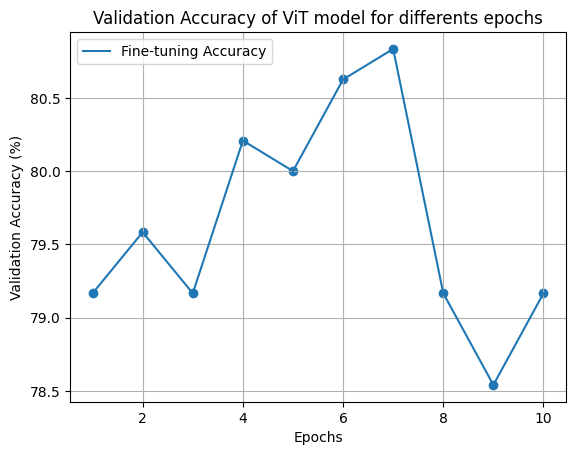

In [24]:
plt.scatter(num_epochs, eval_accuracy)
plt.plot(num_epochs, eval_accuracy, label = "Fine-tuning Accuracy")
plt.ylabel('Validation Accuracy (%)')
plt.xlabel('Epochs')
plt.title('Validation Accuracy of ViT model for differents epochs')
plt.legend()
plt.grid()
plt.show()

In [25]:
from google.colab import files
files.download('result_top1.json')
files.download('result_top5.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

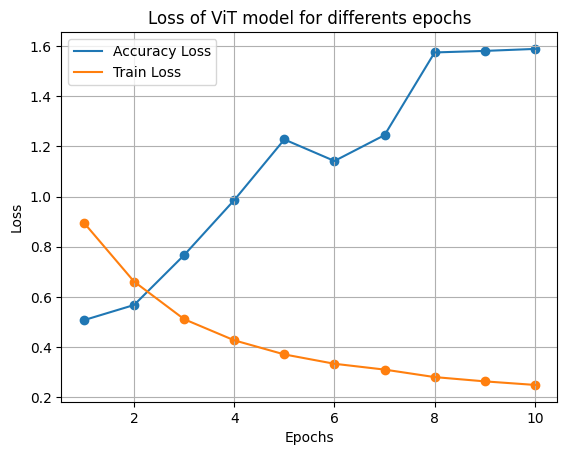

In [ ]:
plt.scatter(num_epochs, eval_loss)
plt.scatter(num_epochs, train_loss)
plt.plot(num_epochs, eval_loss, label = "Validation Loss")
plt.plot(num_epochs, train_loss, label = "Train Loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss of ViT model for differents epochs')
plt.legend()
plt.grid()
plt.show()